## Fetching Data from NBA API

In [71]:
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import leaguedashteamstats
import pandas as pd

# Dictionary of team abbreviations to IDs
team_dict = {
    'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739,
    'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742,
    'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745,
    'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748,
    'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751,
    'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754,
    'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757,
    'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760,
    'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763,
    'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766
}

player_id = 201939  # Steph Curry's player ID
season = '2024-25'

# Fetch player game log
game_log = playergamelog.PlayerGameLog(player_id=player_id, season=season)
df = game_log.get_data_frames()[0]

# Add home/away status and opponent ID
df['Home'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)
df['Opponent'] = df['MATCHUP'].apply(lambda x: x.split()[-1])
df['opponent_id'] = df['Opponent'].map(team_dict)

# Fetch defensive stats vs. position
stats = leaguedashteamstats.LeagueDashTeamStats(
    measure_type_detailed_defense='Opponent',
    per_mode_detailed='PerGame',
    player_position_abbreviation_nullable='G'
)
defense_stats_df = stats.get_data_frames()[0]

# Merge player game logs with defensive stats using suffixes
df = df.merge(defense_stats_df, left_on='opponent_id', right_on='TEAM_ID', how='left', suffixes=('_player', '_team'))

# Select relevant features and target
features = ['MIN_player', 'FGM', 'FTM', 'REB', 'AST', 'STL', 'BLK', 'Home', 'opponent_id', 'OPP_PTS', 'OPP_REB', 'OPP_AST']
target = 'PTS'

# Drop rows with missing values for numerical features and target
df.dropna(subset=features + [target], inplace=True)

# Save to CSV
df.to_csv('steph_curry_game_stats_with_defense_vs_position.csv', index=False)
print("CSV file saved successfully!")


CSV file saved successfully!


## Obtain opponent stats vs position

In [72]:
stats = leaguedashteamstats.LeagueDashTeamStats(
    measure_type_detailed_defense='Opponent',
    per_mode_detailed='PerGame',
    player_position_abbreviation_nullable='G'
)

defense_stats_df = stats.get_data_frames()[0]

# Save to CSV
defense_stats_df.to_csv('defensive_stats_guard_2024_25.csv', index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


## Training Model and Evaluation

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the CSV data
data = pd.read_csv('steph_curry_game_stats_with_defense_vs_position.csv')

# Define features and target variable
X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Print the actual and predicted values
print("Actual values in test set:", y_test.values)
print("Predicted values:", predictions)


Mean Squared Error: 3.8204379036418943
Actual values in test set: [12 23 20]
Predicted values: [14.68378873 24.14089528 21.71957836]


## Visualisation

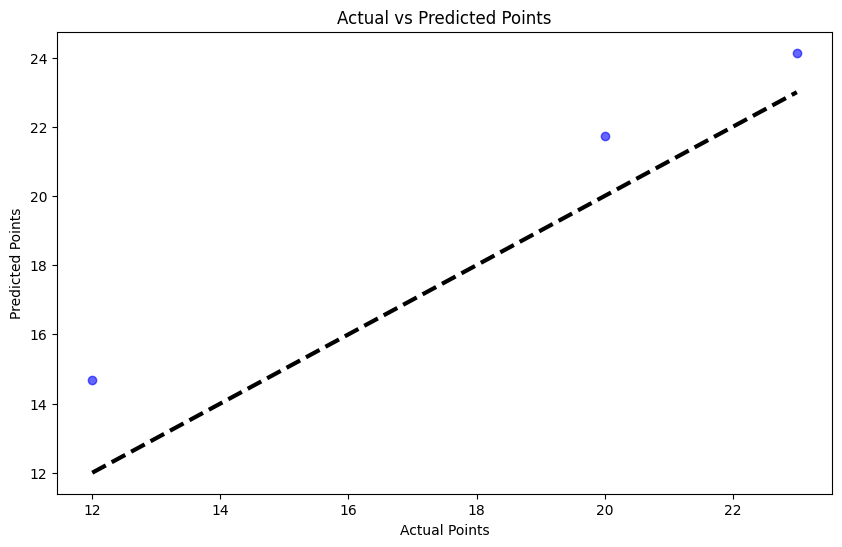

In [74]:
import matplotlib.pyplot as plt
# Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Points')
plt.show()


## Prediction for Future Games

In [75]:
# Example mock data for an upcoming game with the Home feature
mock_data = {
    'MIN_player': [30],
    'FGM': [8],
    'FTM': [5],
    'REB': [3],
    'AST': [4],
    'STL': [0],
    'BLK': [0],
    'Home': [1],  # Example: playing at home
    'opponent_id': [1610612740],
    'OPP_PTS': [52.4],
    'OPP_REB': [19.8],
    'OPP_AST': [12.3],

}
mock_df = pd.DataFrame(mock_data)

# Predict points for the next game
prediction = model.predict(mock_df)
print("Predicted Points for the next game:", prediction[0])


Predicted Points for the next game: 27.041220605373383
